In [2]:
from msidata.dataset_msi_features_with_patients import PreProcessedMSIFeatureDataset
from testing.logistic_regression import get_precomputed_dataloader

import matplotlib.pyplot as plt
from modules.deepmil import Attention
import torch
import pandas as pd
import os

In [4]:
# We need a model with saved weights
model = Attention(hidden_dim=512)
model.load_state_dict(torch.load('./logs/pretrain/97/classifier_checkpoint_10.tar', map_location='cpu'))
print(model)



Attention(
  (attention): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [5]:
# We need a dataset to visualize
test_root_dir="/home/yonis/histogenomics-msc-2019/yoni-code/MsiPrediction/data/msidata/crc_dx/test/"
train_root_dir="/home/yonis/histogenomics-msc-2019/yoni-code/MsiPrediction/data/msidata/crc_dx/train/"

train_dataset = PreProcessedMSIFeatureDataset(
        root_dir=train_root_dir, 
        transform=None, 
        data_fraction=1,
        sampling_strategy='patient',
        append_img_path_with=f'_61',
        tensor_per_patient=True
        
    )
test_dataset = PreProcessedMSIFeatureDataset(
        root_dir=test_root_dir, 
        transform=None, 
        data_fraction=1,
        sampling_strategy='patient',
        append_img_path_with=f'_61',
        tensor_per_patient=True
    )

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True,
        drop_last=False,
        num_workers=16,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        drop_last=False,
        num_workers=16,
    )

Effect of subsampling on dataset:

Raw dataset:
                   Unnamed: 0      label
count  260.000000  260.00000
mean   129.500000    0.15000
std     75.199734    0.35776
min      0.000000    0.00000
25%     64.750000    0.00000
50%    129.500000    0.00000
75%    194.250000    0.00000
max    259.000000    1.00000                

                Sampled dataset:                    
       Unnamed: 0      label
count  260.000000  260.00000
mean   129.500000    0.15000
std     75.199734    0.35776
min      0.000000    0.00000
25%     64.750000    0.00000
50%    129.500000    0.00000
75%    194.250000    0.00000
max    259.000000    1.00000
Effect of subsampling on dataset:

Raw dataset:
                   Unnamed: 0       label
count  100.000000  100.000000
mean    49.500000    0.260000
std     29.011492    0.440844
min      0.000000    0.000000
25%     24.750000    0.000000
50%     49.500000    0.000000
75%     74.250000    1.000000
max     99.000000    1.000000                

 

DOING FORWARD


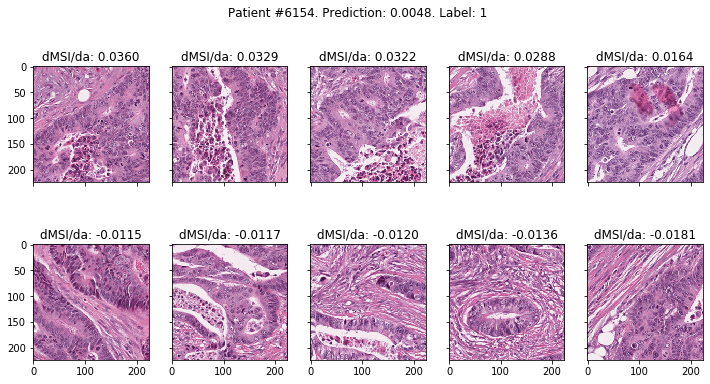

DOING FORWARD


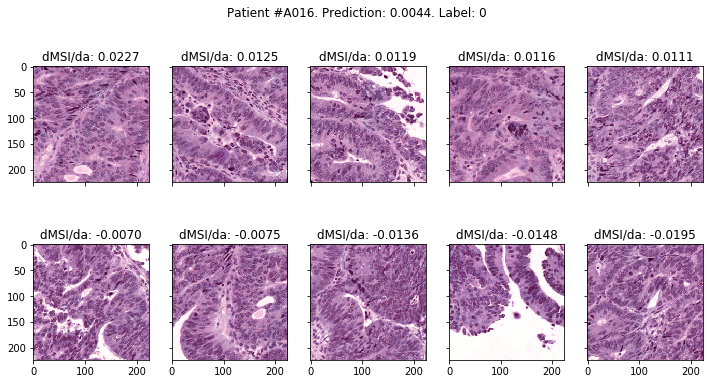

DOING FORWARD


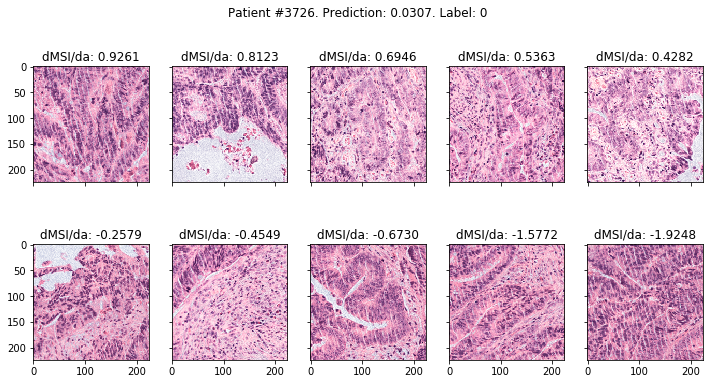

DOING FORWARD


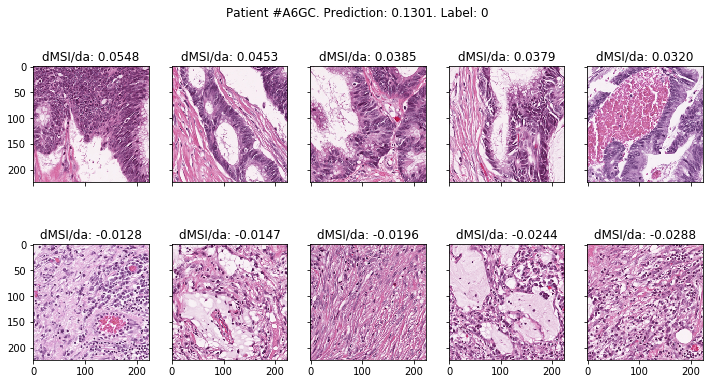

DOING FORWARD


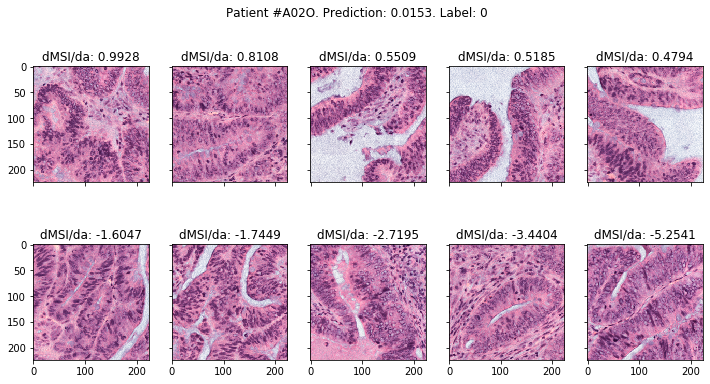

DOING FORWARD


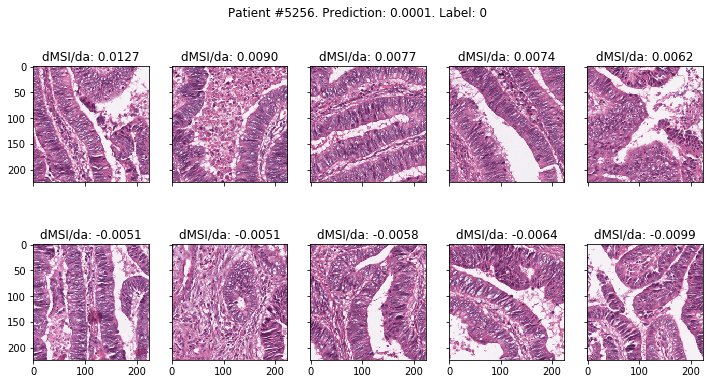

DOING FORWARD


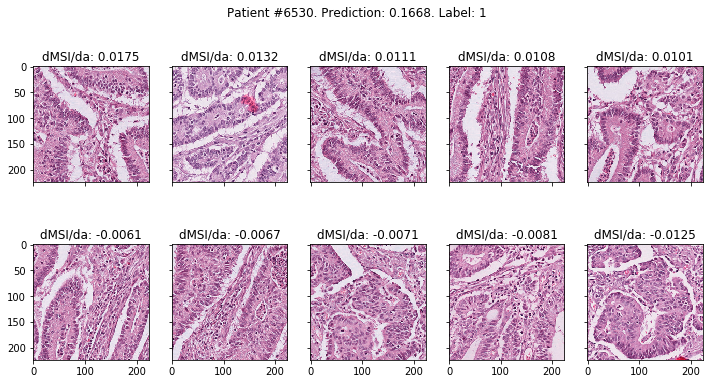

DOING FORWARD


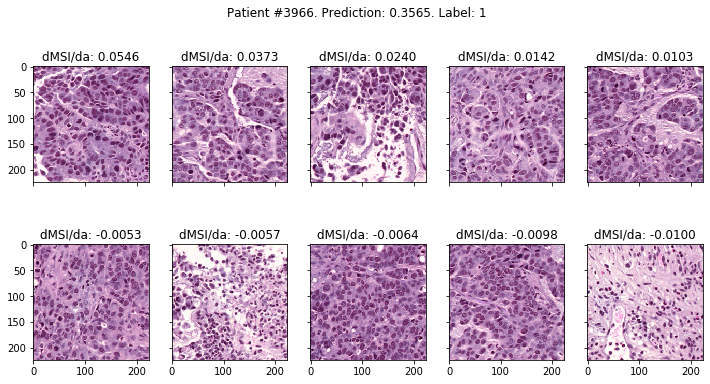

DOING FORWARD


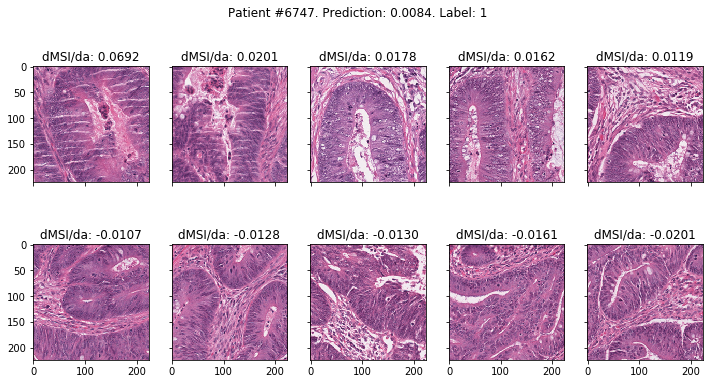

DOING FORWARD


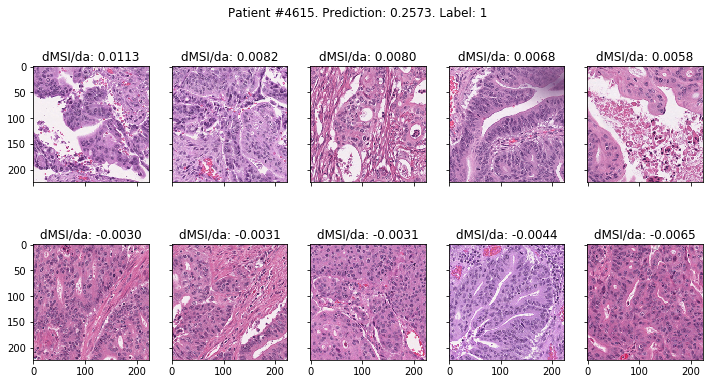

In [12]:
# We need to visualize

from PIL import Image
import os

test_data=pd.read_csv(os.path.join(test_root_dir, 'data.csv'))

mss=0
msi=0
model.train()
for step, data in enumerate(test_loader):
    x=data[0]
    x.requires_grad = True
    y=data[1]
    patient=data[2][0]
    img_path=data[3]
    
    if mss == 5 and msi == 5:
        break
    else:    
        if y.item()==0:
            if mss == 5:
                continue
            mss+=1
        else:
            if msi == 5:
                continue
            msi+=1
  

    Y_out, Y_hat, A = model.forward(x)
#     binary_Y_prob = Y_out.softmax(dim=1)[0][1]
    binary_Y_prob = Y_out.softmax(dim=1)[0][1]
    
    # --- Get MSI gradient labels
    frac = Y_out[0][1] / (Y_out[0].sum())
    frac.backward()
    dMSIdA = model.A_grad    
    # --- Done with MSI Grad labels
    
    test_data.loc[test_data['patient_id']==patient, 'attention'] = A.flatten().detach().numpy()
    test_data.loc[test_data['patient_id']==patient, 'dMSIdA'] = dMSIdA.flatten().detach().numpy()
    test_data.loc[test_data['patient_id']==patient, 'a_dMSIdA'] = (A.flatten()*dMSIdA.flatten()).detach().numpy()
    
    att_data = test_data[test_data['patient_id']==patient].copy()
    grad_data = test_data[test_data['patient_id']==patient].copy()
    
#     assert (patient_image_paths == patient_image_paths.sort_values()).all(), "Sorting gone wrong. Since we have no mapping between tensor index and image, we can't do anything now."

    att_sorted = att_data.sort_values(by=['attention'],ascending=False).copy()
    grad_sorted = grad_data.sort_values(by=['a_dMSIdA'], ascending=False).copy()
    
    top_attention = att_sorted['attention'].head(5)
    bottom_attention = att_sorted['attention'].tail(5)
    
    top_att_images = att_sorted['img'].head(5)
    bottom_att_images = att_sorted['img'].tail(5)
    
    top_grad = grad_sorted['a_dMSIdA'].head(5)
    bottom_grad = grad_sorted['a_dMSIdA'].tail(5)
    
    top_grad_images = grad_sorted['img'].head(5)
    bottom_grad_images = grad_sorted['img'].tail(5)
    
    
    
    


    plot_attention=False
    
    if plot_attention:
        f, axarr = plt.subplots(2,5, sharex=True, sharey=True, figsize=[12,6])
        plt.suptitle(f'Patient #{patient}. Prediction: {binary_Y_prob:.4f}. Label: {y.item()}')
        for idx, (atts, ims, tb) in enumerate(zip([top_attention, bottom_attention], [top_att_images, bottom_att_images], ['top', 'bottom'])):
            for ix, (att, im_path) in enumerate(zip(list(atts), list(ims))):
                im = Image.open(os.path.join(test_root_dir, im_path))
                axarr[idx, ix].imshow(im)
                axarr[idx, ix].set_title(f'A: {att:.4f}')
        plt.show()
        
    
    plot_gradient=True
    if plot_gradient:
        f, axarr = plt.subplots(2,5, sharex=True, sharey=True, figsize=[12,6])
        plt.suptitle(f'Patient #{patient}. Prediction: {binary_Y_prob:.4f}. Label: {y.item()}')
        for idx, (atts, ims, tb) in enumerate(zip([top_grad, bottom_grad], [top_grad_images, bottom_grad_images], ['top', 'bottom'])):
            for ix, (att, im_path) in enumerate(zip(list(atts), list(ims))):
                im = Image.open(os.path.join(test_root_dir, im_path))
                axarr[idx, ix].imshow(im)
                axarr[idx, ix].set_title(f'dMSI/da: {att:.4f}')
        plt.show()
        
        
    



    

    



    
    
    
    
